In [ ]:
# Hamad - Understand CNN Localization and how to implement it.
# Evan - Complete basic pipeline for one model, including testing and accuracy scores.

In [ ]:
# Links
# Stanford Dog Breed Dataset: http://vision.stanford.edu/aditya86/ImageNetDogs/
# Pretrained Pytorch Models: https://pytorch.org/vision/stable/models.html
# CNN Localization + Mapping: http://cnnlocalization.csail.mit.edu/
# Grad-Cam http://gradcam.cloudcv.org/
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/'My Drive'/'Dog Breed Project'

/content/drive/My Drive/Dog Breed Project


In [ ]:
!nvidia-smi

Sat May  8 17:24:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/kazuto1011/grad-cam-pytorch/master/grad_cam.py

--2021-05-08 18:01:24--  https://raw.githubusercontent.com/kazuto1011/grad-cam-pytorch/master/grad_cam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6818 (6.7K) [text/plain]
Saving to: ‘grad_cam.py’

grad_cam.py         100%[===================>]   6.66K  --.-KB/s    in 0.001s  

2021-05-08 18:01:24 (8.48 MB/s) - ‘grad_cam.py’ saved [6818/6818]



In [ ]:
#!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

In [ ]:
#!tar xvf images.tar

In [ ]:
#!rm images.tar

In [ ]:
!ls

 alexnet			   'Dog Breed Final Project'   resnet18.pt
 CAM.jpg			    googlenet		       test.jpg
'Copy of Dog Breed Final Project'   Images		       vgg16
 data				    images.tar
 densenet			    resnet18


In [ ]:
# Turn on matplotlib inline plotting
%matplotlib inline

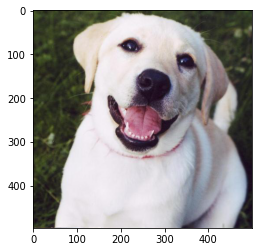

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image

# Plotting a labrador
labrador = Image.open("data/train/n02099712_3197.jpg")
plt.imshow(labrador)

In [ ]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
from torch import topk
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.nn import functional as F
from torch.autograd import Variable
import cv2 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import skimage.transform
import matplotlib.pyplot as plt
import time
import os
import copy

#plt.ion()   # interactive mode

In [ ]:
labelToDog = {
    0: "Labrador",
    1: "French bulldog",
    2: "German shepherd",
    3: "Golden retriever",
    4: "Siberian husky",
    5: "Pomeranian",
    6: "Beagle",
    7: "Rottweiler",
    8: "Chihuahua",
    9: "Great Dane",
}

class DogDataset(Dataset):

    codeToLabel = {
        "n02099712": 0,
        "n02108915": 1,
        "n02106662": 2,
        "n02099601": 3,
        "n02110185": 4,
        "n02112018": 5,
        "n02088364": 6,
        "n02106550": 7,
        "n02085620": 8,
        "n02109047": 9,
    }

    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_list = os.listdir(img_dir)
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        filename = self.img_list[idx]
        img_path = os.path.join(self.img_dir, filename)
        image = read_image(img_path)
        image = self.transform(image.float())
        label = self.codeToLabel[filename[:9]]

        sample = (image, label)
        return sample

In [ ]:
# TODO: Create 3 DogDatasets and corresponding Dataloaders for each of train, val, and test

data_dir = 'data'
transform = transforms.Compose([
                                transforms.Resize((224,224)),    #previously (500, 500)
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
                              ])

image_datasets = {x: DogDataset(os.path.join(data_dir, x), transform)
                 for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4, shuffle=True)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) 
                for x in ['train', 'val', 'test']}
class_names = [labelToDog[x] for x in range(10)]

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device =", device)

Device = cuda:0


In [ ]:
def load_pretrained(model_name):

  if model_name == "resnet18":
    model_conv = models.resnet18(pretrained=True)

  elif model_name == "alexnet":
    model_conv = models.alexnet(pretrained=True)

  elif model_name == "densenet":
    model_conv = models.densenet161(pretrained=True)

  elif model_name == "vgg16":
    model_conv = models.vgg16(pretrained=True)

  elif model_name == "googlenet":
    model_conv = models.googlenet(pretrained=True)

  return model_conv

In [ ]:
def prepare_model(model_name="resnet18"):

  model_conv = load_pretrained(model_name)

  # Parameters of newly constructed modules have requires_grad=True by default
  for param in model_conv.parameters():
    param.requires_grad = False
  
  n_class = 10
  if model_name == "resnet18" or model_name == "googlenet": 
    num_features = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_features, n_class)
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
  elif model_name == "alexnet" or model_name == "vgg16":
    model_conv.classifier._modules['6'] = nn.Linear(in_features=4096, out_features=10, bias=True)
    optimizer_conv = optim.SGD(model_conv.classifier._modules['6'].parameters(), lr=0.001, momentum=0.9)
  elif model_name == "densenet":
    model_conv.classifier = nn.Linear(in_features=2208, out_features=10, bias=True)
    optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

  model_conv = model_conv.to(device)
  criterion = nn.CrossEntropyLoss()

  # Decay LR by a factor of 0.1 every 7 epochs
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

  return model_conv, criterion, optimizer_conv, exp_lr_scheduler

In [ ]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def test_model(model):

  accuracies = {   #track accuracies by class
      0: [0,0],
      1: [0,0],
      2: [0,0],
      3: [0,0],
      4: [0,0],
      5: [0,0],
      6: [0,0],
      7: [0,0],
      8: [0,0],
      9: [0,0]
  }

  model.eval()   # Set model to evaluate mode
  running_corrects = 0.0
  tot = 0

  # Iterate over data.
  for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      tot += len(preds)

    for i in range(len(preds)):
      if preds[0].item()==labels.data[0].item():
        running_corrects += 1
        accuracies[int(labels.data[0].item())][0] += 1
      else:
        accuracies[int(labels.data[0].item())][1] += 1

  for label in accuracies:
    if accuracies[label] == [0,0]:
      accuracies[label] = "N/A"
    elif accuracies[label][1] == 0:
      accuracies[label] = 1.0
    else:
      accuracies[label] = float(accuracies[label][0]) / sum(accuracies[label])

  acc = running_corrects / tot
  print("Overall test accuracy =", acc)
  return accuracies

In [ ]:
model_name = "densenet"
model_conv, criterion, optimizer_conv, exp_lr_scheduler = prepare_model(model_name)

In [ ]:
#model_conv

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=10)

Epoch 0/9
----------
train Loss: 1.0448 Acc: 0.7053
val Loss: 0.2541 Acc: 0.9410

Epoch 1/9
----------
train Loss: 0.4573 Acc: 0.8595
val Loss: 0.1844 Acc: 0.9499

Epoch 2/9
----------
train Loss: 0.4208 Acc: 0.8831
val Loss: 0.1415 Acc: 0.9558

Epoch 3/9
----------
train Loss: 0.4435 Acc: 0.8644
val Loss: 0.1701 Acc: 0.9322

Epoch 4/9
----------
train Loss: 0.3055 Acc: 0.9155
val Loss: 0.1502 Acc: 0.9469

Epoch 5/9
----------
train Loss: 0.3463 Acc: 0.8890
val Loss: 0.1311 Acc: 0.9558

Epoch 6/9
----------
train Loss: 0.3077 Acc: 0.8988
val Loss: 0.1552 Acc: 0.9440

Epoch 7/9
----------
train Loss: 0.2403 Acc: 0.9293
val Loss: 0.1200 Acc: 0.9676

Epoch 8/9
----------
train Loss: 0.2575 Acc: 0.9244
val Loss: 0.1191 Acc: 0.9617

Epoch 9/9
----------
train Loss: 0.2486 Acc: 0.9283
val Loss: 0.1137 Acc: 0.9676

Training complete in 3m 17s
Best val Acc: 0.967552


In [ ]:
accuracies = test_model(model_conv)

Overall test accuracy = 0.9178885630498533


In [ ]:
print("Accuracy by class:")

model_conv.eval()
for label in accuracies:
  print(labelToDog[label]+":", accuracies[label])

Accuracy by class:
Labrador: 0.7777777777777778
French bulldog: 1.0
German shepherd: 1.0
Golden retriever: 1.0
Siberian husky: 1.0
Pomeranian: 1.0
Beagle: 1.0
Rottweiler: 1.0
Chihuahua: 0.6923076923076923
Great Dane: 1.0


In [ ]:
# Save model
torch.save(model_conv.state_dict(), "saved_densenet") # Path is defined when we define what model we're using

In [ ]:
# Load model instead of training
model_conv = models.densenet161(pretrained=False, num_classes = 10)
model_conv.load_state_dict(torch.load("saved_densenet"), strict=False)
model_conv.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

torch.Size([1, 3, 224, 224])


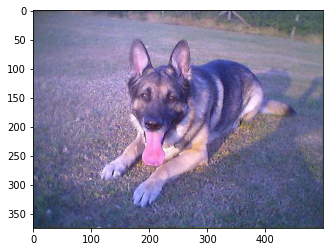

In [ ]:
# CAM
# The picture we'll try to find mappings for
#cam_path = "data/test/n02088364_2360.jpg"
cam_path = "data/test/n02106662_9625.jpg"
raw_image = Image.open(cam_path)
plt.imshow(raw_image)

image = read_image(cam_path)
img_tensor = transform(image.float()).to(device)[None]     #Using same transforms used during training. The [None] adds a batch dimension so the forward() method doesn't complain
print(img_tensor.shape)

In [ ]:
# Make sure we use model_conv.eval()
model_conv.eval()
with torch.no_grad():
    pred = model_conv(img_tensor)
    print(pred)

tensor([[-1.5801,  1.5566, 10.8197, -4.3857,  1.4034, -3.4135, -1.7539, -1.1653,
         -1.9894, -0.1401]], device='cuda:0')


In [ ]:
_, index = torch.max(pred, 1)
print(index)
#F.softmax(pred, dim=1)[0]
index = index.cpu().numpy()[0]
dog_breed = labelToDog[index]
print(dog_breed)

tensor([2], device='cuda:0')
German shepherd


In [ ]:
# "Hooks" the model - gets the final layer
class SaveFeatures():
    features=None
    def __init__(self, m):
       self.hook = m.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, input, output):
       self.features = ((output.cpu()).data).numpy()
       
    def remove(self):
       self.hook.remove()

In [ ]:
final_layer = None
weight_softmax_params = None
if model_name == "resnet18":
  final_layer = model_conv._modules.get("layer4")
  weight_softmax_params = list(model_conv._modules.get('fc').parameters())
elif model_name == "densenet":
  final_layer = model_conv._modules.get("features")._modules.get('norm5')
  weight_softmax_params = list(model_conv._modules.get('classifier').parameters())
elif model_name == "googlenet":
  final_layer = model_conv._modules.get("inception5b")
  weight_softmax_params = list(model_conv._modules.get('fc').parameters())

weight_softmax = np.squeeze(weight_softmax_params[0].cpu().data.numpy())

print(type(final_layer))
print(final_layer)

<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
BatchNorm2d(2208, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [ ]:
activated_features = SaveFeatures(final_layer)

In [ ]:
# Get the prediction and the probabilties
prediction = model_conv(img_tensor)
pred_probabilities = F.softmax(prediction).data.squeeze()
activated_features.remove()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# http://cnnlocalization.csail.mit.edu/
def getCAM(feature_conv, weight_fc, class_idx):
    _, nc, h, w = feature_conv.shape
    print("feature_conv.shape:", feature_conv.shape)
    print("weight_fc[class_idx].shape", weight_fc[class_idx].shape)
    cam = weight_fc[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    return [cam_img]

In [ ]:
# Get the class
class_idx = topk(pred_probabilities,1)[1].int()

In [ ]:
overlay = getCAM(activated_features.features, weight_softmax, class_idx)

feature_conv.shape: (1, 2208, 7, 7)
weight_fc[class_idx].shape (2208,)


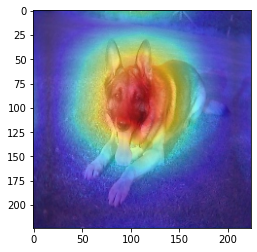

In [ ]:
plt.imshow(skimage.transform.resize(cv2.imread(cam_path), img_tensor.shape[2:4]))
plt.imshow(skimage.transform.resize(overlay[0], img_tensor.shape[2:4]), alpha=0.5, cmap='jet')
plt.savefig("results/CAM_"+model_name+"_"+dog_breed+".png", bbox_inches='tight')

In [ ]:
from grad_cam import (
    BackPropagation,
    Deconvnet,
    GradCAM,
    GuidedBackPropagation,
    occlusion_sensitivity,
)
import cv2
import matplotlib.cm as cm

In [ ]:
# Author:   Kazuto Nakashima
# URL:      http://kazuto1011.github.io

def gradcam_preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (224,) * 2)
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image

def gradcam_preprocess2(image_path):
  raw_image = read_image(image_path)
  image = transform(raw_image.float()).to(device)
  raw_image = cv2.imread(image_path)
  raw_image = cv2.resize(raw_image, (224,) * 2)
  return image, raw_image

def gradcam_load_images(image_paths):
    images = []
    raw_images = []
    print("Images:")
    for i, image_path in enumerate(image_paths):
        print("\t#{}: {}".format(i, image_path))
        image, raw_image = gradcam_preprocess2(image_path)
        images.append(image)
        raw_images.append(raw_image)
    return images, raw_images

def save_gradient(filename, gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    cv2.imwrite(filename, np.uint8(gradient))

def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    #raw_image = raw_image.numpy()
    #print("foo:", cmap.shape)
    #print("bar:", raw_image.shape)
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    cv2.imwrite(filename, np.uint8(gcam))
    return filename

features.norm5


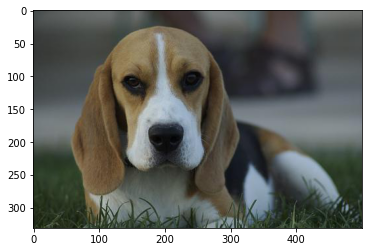

In [ ]:
image_paths = ["data/test/n02106662_9625.jpg", "data/test/n02088364_2360.jpg"]
arch = model_name

target_layers = {
    "resnet18": "layer4",
    "densenet": "features.norm5",
    "googlenet": "inception5b"
}
target_layer = target_layers[model_name]
print(target_layer)

topk_classes = 1
output_dir = "./results"
classes = [
    "Labrador",
    "French bulldog",
    "German shepherd",
    "Golden retriever",
    "Siberian husky",
    "Pomeranian",
    "Beagle",
    "Rottweiler",
    "Chihuahua",
    "Great Dane"
]

doge = Image.open(image_paths[1])
plt.imshow(doge)

In [ ]:
images, raw_images = gradcam_load_images(image_paths)
print(type(images[0]))
print(images[0].shape)

Images:
	#0: data/test/n02106662_9625.jpg
	#1: data/test/n02088364_2360.jpg
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


Grad-CAM/Guided Backpropagation/Guided Grad-CAM:
Images:
	#0: data/test/n02106662_9625.jpg
	#1: data/test/n02088364_2360.jpg


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:770: UserWarning: Using non-full backward hooks on a Module that does not take as input a single Tensor or a tuple of Tensors is deprecated and will be removed in future versions. This hook will be missing some of the grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using non-full backward hooks on a Module that does not take as input a "


	#0: German shepherd (0.99979)
	#1: Beagle (0.99915)


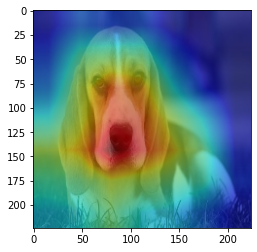

In [ ]:
print("Grad-CAM/Guided Backpropagation/Guided Grad-CAM:")

model_conv.to(device)
model_conv.eval()

images, raw_images = gradcam_load_images(image_paths)
images = torch.stack(images).to(device)

bp = BackPropagation(model=model_conv)
probs, ids = bp.forward(images)  # sorted

gcam = GradCAM(model=model_conv)
_ = gcam.forward(images)

gbp = GuidedBackPropagation(model=model_conv)
_ = gbp.forward(images)

for i in range(topk_classes):
        # Guided Backpropagation
        gbp.backward(ids=ids[:, [i]])
        gradients = gbp.generate()

        # Grad-CAM
        gcam.backward(ids=ids[:, [i]])
        regions = gcam.generate(target_layer=target_layer)

        for j in range(len(images)):
            print("\t#{}: {} ({:.5f})".format(j, classes[ids[j, i]], probs[j, i]))

            # Guided Backpropagation
            save_gradient(
                filename=os.path.join(
                    output_dir,
                    "{}-{}-guided-{}.png".format(j, arch, classes[ids[j, i]]),
                ),
                gradient=gradients[j],
            )

            # Grad-CAM
            gradcam_filename = save_gradcam(
                filename=os.path.join(
                    output_dir,
                    "{}-{}-gradcam-{}-{}.png".format(
                        j, arch, target_layer, classes[ids[j, i]]
                    ),
                ),
                gcam=regions[j, 0],
                raw_image=raw_images[j],
            )

            # Guided Grad-CAM
            save_gradient(
                filename=os.path.join(
                    output_dir,
                    "{}-{}-guided_gradcam-{}-{}.png".format(
                        j, arch, target_layer, classes[ids[j, i]]
                    ),
                ),
                gradient=torch.mul(regions, gradients)[j],
            )

            gradcam_result = Image.open(gradcam_filename)
            plt.imshow(gradcam_result)